In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv

In [12]:
RUNTIME = 240
NOMINAL_FREQUENCY = 2.5e9
CORES = 64
POWER_SCALER = 550
PERIOD = 1
FREQ_NAME = 'frequency normalized to nominal frequency'
IPC_NAME = 'instructions per cycle on one core normalized\nto maximal throughput of four instructions'
PREFIX = 'nominal'

In [13]:
def get_power(name):
    with open(f'datafiles/{PREFIX}-{name}-power.csv') as fp:
        reader = csv.DictReader(fp)
        data = next(reader)
        return [ float(data['average']), float(data['stddev']) ]

In [14]:
def get_perf(name):
    with open(f'datafiles/{PREFIX}-{name}-perf.data') as fp:
        reader = csv.reader(fp, delimiter='!')
        # skip the two blank lines
        next(reader)
        next(reader)
        l = []
        for row in reader:
            timestamp, socket, cores, value, _, metric, _, _, _, _ = row
            l.append({'time': timestamp, 'socket': socket, 'value': float(value), 'metric': metric})
        # cut away the last two seconds
        l = l[:-4]
        
        df = pd.pivot_table(pd.DataFrame(l), index=['time','socket'], columns='metric', values='value')
        df['IPC'] = df['instructions'] / df['cpu-cycles']
        if name.startswith('no-ht'):
            scaler = 2
        else:
            scaler = 1
        df[IPC_NAME] = df['IPC'] / 2 / scaler
        df[FREQ_NAME] = df['cpu-cycles'] / PERIOD / NOMINAL_FREQUENCY / CORES * scaler
        
        df = df.reset_index().drop(columns=['IPC', 'instructions', 'cpu-cycles'])
        df['name'] = name
        df = df.set_index(['socket', 'name'])
        return df

             name                                             Metric     value
0        with SMT          frequency normalized to nominal frequency  0.809569
1        with SMT          frequency normalized to nominal frequency  0.815321
2        with SMT          frequency normalized to nominal frequency  0.809845
3        with SMT          frequency normalized to nominal frequency  0.815803
4        with SMT          frequency normalized to nominal frequency  0.808248
...           ...                                                ...       ...
1879  without SMT  instructions per cycle on one core normalized\...  0.804353
1880  without SMT  instructions per cycle on one core normalized\...  0.813424
1881  without SMT  instructions per cycle on one core normalized\...  0.804363
2824     with SMT                                              power  0.924616
2825  without SMT                                              power  0.888791

[1882 rows x 3 columns]
Rectangle(xy=(-0.4, 0), wid

<ipython-input-15-ea7f71b5a3ea>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.array(ax1.get_yticks()*POWER_SCALER, dtype='int'))


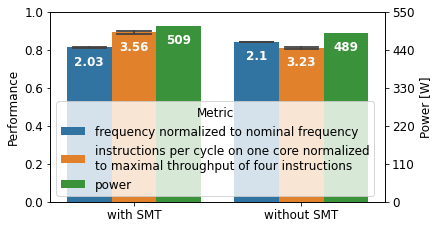

In [15]:
ht_power = get_power('ht')[0]
no_ht_power = get_power('no-ht')[0]
ht_perf = get_perf('ht')
no_ht_perf = get_perf('no-ht')

df = pd.DataFrame(ht_perf)
df = df.append(no_ht_perf)
df = df.reset_index()
df = df.append({'name': 'ht', 'power': ht_power}, ignore_index=True)
df = df.append({'name': 'no-ht', 'power': no_ht_power}, ignore_index=True)

df['power'] = df['power'] / POWER_SCALER

melt = pd.melt(df, id_vars=['name'], value_vars=[FREQ_NAME, IPC_NAME, 'power']).dropna()
melt = melt.rename(columns={'variable': 'Metric'})
rename = {'no-ht': 'without SMT', 'ht': 'with SMT'}
melt.name = melt.name.apply(lambda name: rename[name])

print(melt)

parameters = {
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.fontsize' : 12,
          'legend.title_fontsize' : 12,
          'lines.linewidth' : 1,
 }
plt.rcParams.update(parameters)

fig, ax = plt.subplots(figsize = (6, 3.5))



colors = sns.color_palette()
colors = [colors[1], colors[0], colors[2]]

sns.set_palette(sns.color_palette(colors))

ax1 = sns.barplot(x='name', y="value", hue="Metric", data=melt, ax=ax, capsize=.2,  ci="sd")
ax1.set_ylim(ymin=0, ymax=1)
ax1.set_ylabel('Relative Performance')
ax1.set(xlabel=None)
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.array(ax1.get_yticks()*POWER_SCALER, dtype='int'))
ax2.set_ylabel('Power [W]')

mul = [NOMINAL_FREQUENCY / 1e9, 4, POWER_SCALER, NOMINAL_FREQUENCY / 1e9, 4, POWER_SCALER]

bars = list(ax1.patches)
bars.sort(key=lambda bar: bar.get_x())

for bar, mul in zip(bars, mul):
    num = bar.get_height() * mul
    if num > 100:
        num = int(round(num, 0))
    else:        
        num = round(num, 2)
    print(bar, mul, num)
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() - 0.075, str(num),
            color='white', va='center', ha='center', fontsize=12, fontweight='bold')
    
print(f"power stddev with SMT: {get_power('ht')[1]}")
print(f"power stddev without SMT: {get_power('no-ht')[1]}")

plt.savefig('../../paper/fig/firestarter_frequency.pdf', bbox_inches='tight')

In [ ]:
round(np.std(melt[melt.name == "with SMT"][melt.metric == FREQ_NAME].value * 1000), 2)

In [7]:
round(np.std(melt[melt.name == "without SMT"][melt.metric == FREQ_NAME].value * 1000), 2)

/nix/store/zdxy58fzw4vzxxhjgvs8sbwmk6cfbnkw-python3-3.7.9-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.82

In [8]:
round(np.std(melt[melt.name == "with SMT"][melt.metric == IPC_NAME].value), 3)

/nix/store/zdxy58fzw4vzxxhjgvs8sbwmk6cfbnkw-python3-3.7.9-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.008

In [9]:
round(np.std(melt[melt.name == "without SMT"][melt.metric == IPC_NAME].value), 3)

/nix/store/zdxy58fzw4vzxxhjgvs8sbwmk6cfbnkw-python3-3.7.9-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.004